# Bayesian Inference Lab 1 

Varun Nayyar

This is an Ipython notebook (an R equivalent now exists) that allows me to put my notes and code in a single place, before exporting a pdf or webpage I can use to review later on. 

## R

### Why?

* If you want to see how a recently developed method that was just published works, you can assured that the researcher's will implement their package in R, so seeing it's real world performance is as simple as installing the relevant package. 
* Any kind of method you want to use is available out of the box, you don't have to do much research and searching to find good implementations
* It's the default programming language used by most researching statisticians and knowledge of R is essential for any kind of research statistics. 
* It is easy to get started with for basic work.
* R is a language you have to know for a stats degree, it's NOT optional!

### Why Not?

* It is a one trick pony - it's good for stats, and that's it
    * Very poorly designed languaged
    * Over specialized - general purpose work is very difficult with R
* Very poor stability, large >100Mb datasets usually cause R to crash.
* Constantly in flux, R code written now is unlikely to work next year.
* Very difficult to deal with complexity, Object oriented design very poorly implemented.



## Python

### Why?
Python is a full featured and mature language, as such it

* Will work a year later, which is not the case with much R code. 
* Has very well designed features which makes writing complex code much easier. Even simple code is easier in Python.
* Has functionality to do many things like webscraping, webpage hosting, file parsing etc.
* Performance wise, Python tends to have extremely efficient algorithms implmented and is usually faster than R.  
* Superb package support, for nearly anything, you can just import it.
    * Numpy for fast (native C speeds) computations
    * Scipy for many useful functions in fields like signal processing, optimization, linalg, stats etc
    * Matplotlib (and ggplot, seaborn etc) for really nice visualisation
    * Pandas for powerful dataframes
    * PyMC for efficient Monte Carlo computations, with performance similar to BUGS
    * Rpy - call R code from Python!
  
### Why Not?

* Single threaded - does not scale well with available computing power
* Limited adoption by statistical community, and as such no packages available for implementation
* More general purpose makes initial learning curve a little steeper for stats use, but long term learning curve is much shallower than R.
    

##Other Languages

Julia has become popular of late due to performance promises, however it is even more bleeding edge than R and has very limited support. It is my opinion ([and others](https://darrenjw.wordpress.com/2013/12/23/scala-as-a-platform-for-statistical-computing-and-data-science/)) that taking a programming language and overspecialising is a bad approach (like R, Matlab etc.), I would much rather take a well designed general language and add numeric capabilities. This has the advantage of a well designed language with powerful data types with powerful numerics, as opposed to a language with powerful numerics and little else.

For those interested in Big Data, a functional language like [Scala](https://www.coursera.org/course/progfun), OCaml or Haskell would be worth learning (same language family as Julia). Due to the constraints of the language, far greater optimizations can be made, and this allows the program to scale from 1 computer to many with very little additional code. In contrast, Python and R are unable to use more than a single core for computation (unless written explicitly mutli-threaded which is quite difficult and not recommendend in general).

In [2]:
import numpy as np #very useful
from scipy.stats import gamma
shape = 24890 + 1
rate = 65+ 0.01
level = 0.05

gamRV = gamma(a = shape, scale = 1/rate)

This creates a gamma random variable with useful functions and I don't have to keep specifying it's parameters (which is nice). For full usage features, check out the reference below 
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

In [3]:
lower = gamRV.ppf(0.025) # qgamma equivalent
lower

378.13762557414162

In [4]:
upper = gamRV.ppf(0.975)
upper

387.65062700867895

In [5]:
mean = gamRV.stats('m') #Theoretical mean, isn't that nice!
print mean

382.879556991


In [7]:
singleMCSet = gamRV.rvs(size = 500) #rgamma equivalent
MCSet = gamRV.rvs(size = (250,500)) #larger draw
MCSet[0, :20] # let's look at a bit of one of them

array([ 381.09639501,  387.36178786,  383.33321384,  380.69376495,
        381.27429748,  383.34820132,  379.48558499,  378.49217774,
        383.79291013,  380.34901093,  386.59168873,  381.09134306,
        383.34117878,  380.89131984,  384.67255916,  382.16871535,
        382.91433931,  383.75699992,  383.75597059,  377.70795735])

Note that I've drawn 250 lots of  500 values. This is an implementation problem. Python and R are high level languages  with low level language interfaces. This means simple constructs like loops are extremely slow and repeated calls to any function have high overhead. Rather than call gamRV.rvs 250 times, I call it once with more work and get the results with less work. And then you can use functions like `map` in python or `apply` in R to work on datasets quickly (these are loop like, but much quicker).

This is really not a problem when it's 250 repeats of 500 samples, but add a few zeros on to the end, and this becomes a problem. You might instead run into issues where you can't store all the data as it requires too much RAM, in which case the loop is unavoidable. 

Either way, I'll show both approaches here.

In [7]:
#loop approach

numMCruns = 250
numSamples = 500
lowVals = np.zeros(numMCruns) 
upperVals = np.zeros(numMCruns)
# empty vectors to store the data, since I know how much storage I need, it's better to preallocate

for i in range(numMCruns):
    singleMCSet = gamRV.rvs(size = numSamples)
    lowVals[i], upperVals[i] = np.percentile(singleMCSet, [2.5, 97.5]) 
    #double assignment is nice syntax

print lowVals[:10] 
print upperVals[:10] #Let's have a look at what we got

[ 378.88660509  378.0188825   378.4714322   377.64924658  378.27916411
  377.94931986  378.0069082   378.00793627  378.24524166  378.25511904]
[ 387.5837546   387.2105916   387.81106068  387.21965834  388.08347164
  387.78294871  387.33967418  387.99448637  387.2507709   387.66806098]


In [8]:
#Map/apply approach

MC = 250
nSamps = 500
#Turning this into a function for later use
def credInts(numMCruns = 250, numSamples=500):
    """
    Function Docstring:
    Numpy functions have automatic mapping, here I apply across the columns (axis=1), 
    so it treats each row as the dataset to apply the function,
    If i had it the other way around, i.e. size = (numSamples, numMCruns), 
    I would apply across the rows, i.e. axis = 0
    """
    MCSet = gamRV.rvs(size = (numMCruns,numSamples)) # 250 rows, 500 columns 
    lowVals, upperVals = np.percentile(MCSet,[2.5,97.5], axis = 1)
    return lowVals, upperVals

lowValsMap, upperValsMap = credInts(MC, nSamps)

print lowValsMap[:10]
print upperValsMap[:10]

[ 378.19690439  377.96703478  377.88661431  377.89748556  378.40180758
  378.0452382   378.48961808  378.21563124  378.30332932  378.29158517]
[ 387.25485772  387.33233217  387.99290551  387.51102376  387.49563638
  387.38906716  387.41738282  387.48830119  387.74634937  387.83578444]


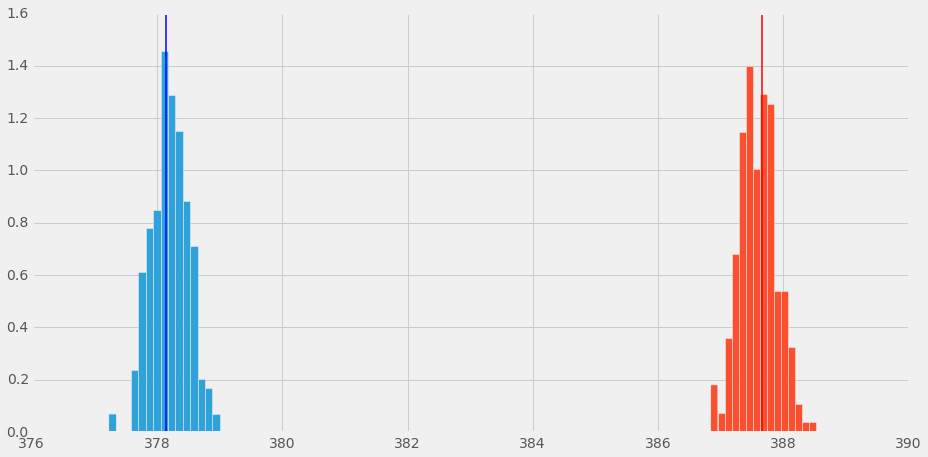

In [9]:
#Now lets plot
from matplotlib import pyplot as plt 
#using matlab style plotting package
%matplotlib inline 
# for displaying in the notebook

from matplotlib.style import use
use(['ggplot', 'fivethirtyeight']) #nicer graphics than default

plt.figure(figsize = (14,7))
a = plt.hist(lowValsMap, normed=True, bins = 15)
b = plt.hist(upperValsMap, normed=True, bins = 15)

#true values
plt.axvline(lower, lw=1.5)
plt.axvline(upper, color='r', lw=1.5)

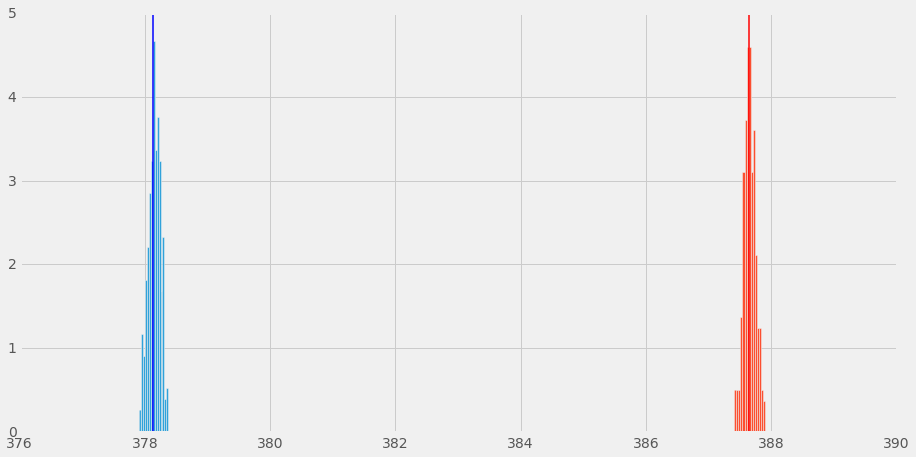

In [10]:
# let's use our previous function
low5k, upp5k = credInts(numMCruns=250, numSamples=5000)
plt.figure(figsize = (14,7))
plt.xlim((376, 390))
a = plt.hist(low5k, normed=True, bins = 15)
b = plt.hist(upp5k, normed=True, bins = 15)

#true values
plt.axvline(lower, lw = 1.5)
plt.axvline(upper, color='r', lw=1.5)

In [11]:
lowprec, uppprec = credInts(numMCruns=250, numSamples=70000)

print "Lrange: ", np.ptp(lowprec) #ptp = range finder
print "Urange: ", np.ptp(uppprec)

Lrange:  0.147539159999
Urange:  0.134334414068


It takes roughly 70,000 samples or so to reduce the range to 0.15 or so

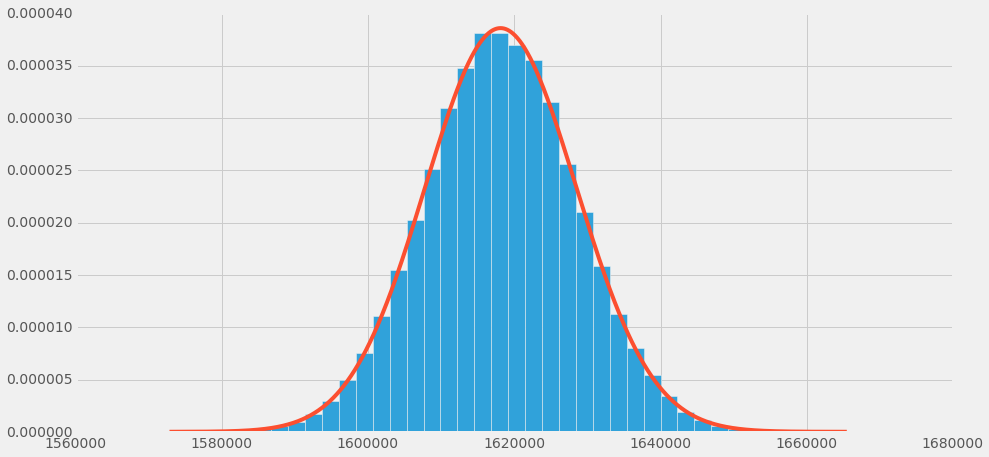

In [15]:
# c)
from scipy.stats import nbinom

nbinRV = nbinom(n=shape, p = 1/(rate+1))
# set it to the requisite values

randVals = nbinRV.rvs(100000) #draw samples
#more samples = more like theoretical pmf

plt.figure(figsize=(14,7))
a = plt.hist(randVals, bins = 40, normed=True)
# print randVals[:50]
x = np.arange(min(randVals)-10, max(randVals)+10) #get integer values for x axis in same region

plt.plot(x, nbinRV.pmf(x)) #pmf = probability mass functions

1d
Obviously the algebraic approaches allow us to work with limited computation power, we get more exact answers more quickly, and as such we don't have to worry about issues such as convergence and correlation of samples.

However, if we don't choose convenient priors, we do obtain an intractable expression for the posterior, which means we are very limited if we choose to stay with algebraic analysis only.

### Part 2

For this part, I'm going to use pandas to read the data. pandas.DataFrame has much of the same functionality as R's tables and has many useful features included. I

In [ ]:
import pandas as pd
dat = pd.read_table("Data/tuberculosis.txt", names = ['a', 'c', 'p', 'mu'], sep=' ')
dat.head()

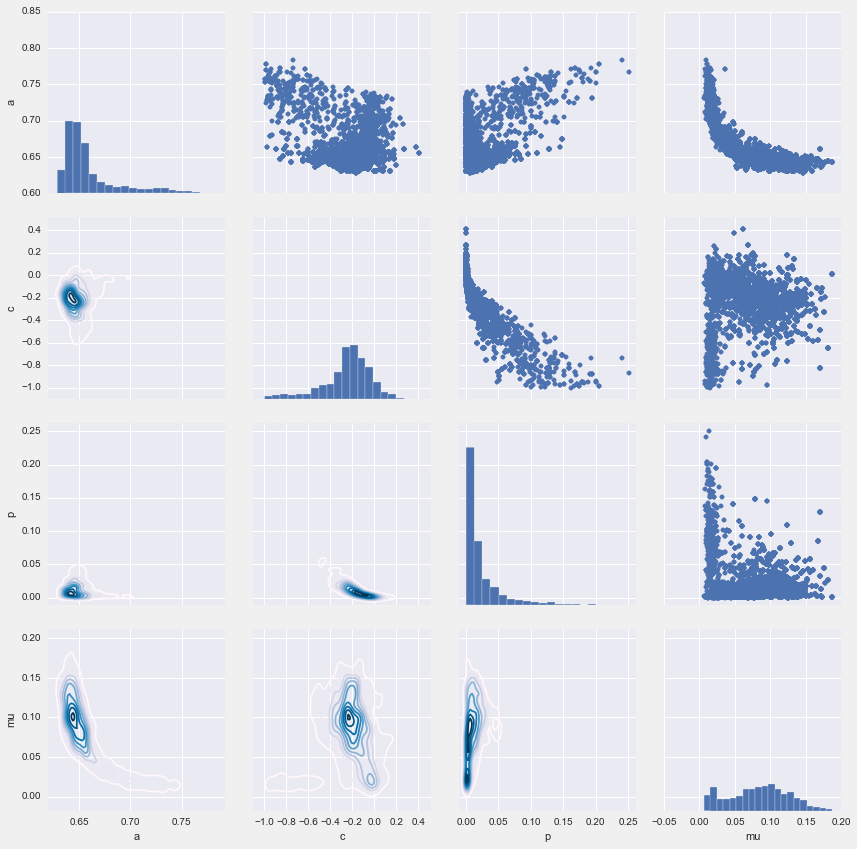

In [41]:
import seaborn as sns # nice multivariate visualisation library
p = sns.PairGrid(dat)
p.map_upper(plt.scatter)
p.map_diag(plt.hist, bins = 20)
p.map_lower(sns.kdeplot, cmap = "PuBu") 
# ^^this line quite slow for large datasets - but gives nice visualisations

In [ ]:
def relfitness(c, tau, delta, er, es, p):
    num = 1.0/tau + 1.0/(delta+er)
    denom - 1.0/tau + 1.0/(delta+es+p)
    return (1.0-c)* num/denom
